In [71]:
import random
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# Helper Functions
def flatten(mat):
    return [num for row in mat for num in row]

def has_zero(mat):
    return 0 in flatten(mat)

def transpose(mat):
    return list(map(list, zip(*mat)))

def reverse(mat):
    return [list(reversed(row)) for row in mat]

def print_board(state):
    for row in get_matrix(state):
        print(row)
    print()

In [5]:
# Game Functions
def new_game_matrix(n):
    return [[0] * n for _ in range(n)]

def add_two(mat):
    if not has_zero(mat):
        return mat
    empty_cells = [(i, j) for i in range(len(mat)) for j in range(len(mat[i])) if mat[i][j] == 0]
    a, b = random.choice(empty_cells)
    mat[a][b] = 2
    return mat

def game_status(mat):
    if has_zero(mat):
        return 'not over'
    for i in range(len(mat)):
        for j in range(len(mat[0]) - 1):
            if mat[i][j] == mat[i][j + 1]:
                return 'not over'
    for i in range(len(mat) - 1):
        for j in range(len(mat[0])):
            if mat[i][j] == mat[i + 1][j]:
                return 'not over'
    return 'lose'

def merge_left(matrix):
    def merge_row(row):
        merged_row, prev_tile, score_increment = [], 0, 0
        for tile in row:
            if tile == 0:
                continue
            if prev_tile == 0:
                prev_tile = tile
            elif prev_tile == tile:
                merged_row.append(prev_tile * 2)
                score_increment += prev_tile * 2
                prev_tile = 0
            else:
                merged_row.append(prev_tile)
                prev_tile = tile
        merged_row.append(prev_tile)
        while len(merged_row) < len(row):
            merged_row.append(0)
        return merged_row, merged_row != row, score_increment

    merged_rows = [merge_row(row) for row in matrix]
    merged_matrix = [row[0] for row in merged_rows]
    valid_move = any(row[1] for row in merged_rows)
    score_increment = sum(row[2] for row in merged_rows)
    return merged_matrix, valid_move, score_increment

def merge_right(mat):
    mat, valid, score = merge_left(reverse(mat))
    return reverse(mat), valid, score

def merge_up(mat):
    mat, valid, score = merge_left(transpose(mat))
    return transpose(mat), valid, score

def merge_down(mat):
    mat, valid, score = merge_left(reverse(transpose(mat)))
    return transpose(reverse(mat)), valid, score

def make_state(matrix, score):
    return matrix, score

def get_matrix(state):
    return state[0]

def get_score(state):
    return state[1]

def make_new_game(n):
    starting_matrix = add_two(add_two(new_game_matrix(n)))
    return make_state(starting_matrix, 0)

def execute_move(state, matrix_updater):
    current_score = get_score(state)
    next_matrix, valid_move, score_increment = matrix_updater(get_matrix(state))
    if not valid_move:
        return state, False
    return make_state(add_two(next_matrix), current_score + score_increment), True

def up(state):
    return execute_move(state, merge_up)

def down(state):
    return execute_move(state, merge_down)

def left(state):
    return execute_move(state, merge_left)

def right(state):
    return execute_move(state, merge_right)


In [9]:
# Game Logic Functions
def perform_move(state, move):
    if move == Move.UP:
        return up(state)
    elif move == Move.DOWN:
        return down(state)
    elif move == Move.LEFT:
        return left(state)
    elif move == Move.RIGHT:
        return right(state)

class Move(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

In [11]:
# Monte Carlo Simulation Functions
def simulation_rollout(gamestate, iterations, max_depth):
    score = 0
    for _ in range(iterations):
        new_state = gamestate
        depth = 0
        while game_status(get_matrix(new_state)) == "not over" and depth < max_depth:
            random_move = random.choice(list(Move))
            new_state, _ = perform_move(new_state, random_move)
            depth += 1
        score += get_score(new_state)
    return score / iterations

# Selection Function
def select_best_move(action_score, action_tries, total_tries, exploration_param):
    action_heuristic = action_score / action_tries + exploration_param * np.sqrt(np.log(total_tries + 1) / action_tries)
    best_move_index = np.argmax(action_heuristic)
    return Move(best_move_index)

# Expansion Function
def expand_moves(current_state, valid_moves, iterations, max_depth):
    action_score = np.array([0, 0, 0, 0])
    action_tries = np.array([0, 0, 0, 0])
    max_score = 0

    for move in Move:
        _, valid = perform_move(current_state, move)
        if valid:
            valid_moves.append(move)
        else:
            action_tries[move.value] = iterations
            action_score[move.value] = -1000000
            continue
        
        for _ in range(iterations):
            montecarlo_state, _ = perform_move(current_state, move)
            montecarlo_score = simulation_rollout(montecarlo_state, 1, max_depth)
            
            action_tries[move.value] += 1
            action_score[move.value] += montecarlo_score
            
            max_score = max(max_score, montecarlo_score)
    
    return action_score, action_tries, max_score

# Backpropagation Function
def backpropagate(action_score, action_tries, current_state, iterations, max_depth, exploration_param):
    for total_tries in range(iterations):
        best_move = select_best_move(action_score, action_tries, total_tries, exploration_param)
        
        montecarlo_state, _ = perform_move(current_state, best_move)
        montecarlo_score = simulation_rollout(montecarlo_state, 1, max_depth)
        
        action_tries[best_move.value] += 1
        action_score[best_move.value] += montecarlo_score
    
    best_move_index = np.argmax(action_score / action_tries)
    best_move = Move(best_move_index)
    
    return best_move


In [19]:
# Game Loop with MCTS
def play_game_mcts(iterations, max_depth):
    current_state = make_new_game(4)
    print('Initial Board:')
    print_board(current_state)
    
    while game_status(get_matrix(current_state)) == "not over":
        valid_moves = []
        # Selection Function
        action_score, action_tries, max_score = expand_moves(current_state, valid_moves, iterations, max_depth)
        
        best_move = backpropagate(action_score, action_tries, current_state, iterations, max_depth, max_score)
        
        current_state, _ = perform_move(current_state, best_move)
        
        print('Board after move:')
        print_board(current_state)
        print(f'Score: {get_score(current_state)}')
        print(f'Max Tile: {np.max(get_matrix(current_state))}')
    
    print('Final Board:')
    print_board(current_state)
    print(f'Final Score: {get_score(current_state)}')


In [113]:
play_game_mcts(iterations=1000, max_depth=15)

Initial Board:
[0, 0, 0, 0]
[0, 2, 0, 0]
[0, 0, 0, 0]
[0, 2, 0, 0]

Board after move:
[0, 0, 0, 2]
[2, 0, 0, 0]
[0, 0, 0, 0]
[2, 0, 0, 0]

Score: 0
Board after move:
[0, 0, 0, 2]
[0, 2, 0, 2]
[0, 0, 0, 0]
[0, 0, 0, 2]

Score: 0
Board after move:
[0, 2, 0, 4]
[0, 0, 0, 2]
[0, 0, 0, 2]
[0, 0, 0, 0]

Score: 4
Board after move:
[0, 2, 0, 4]
[0, 0, 0, 4]
[0, 2, 0, 0]
[0, 0, 0, 0]

Score: 8
Board after move:
[0, 0, 2, 4]
[0, 0, 0, 4]
[0, 0, 0, 2]
[0, 0, 0, 2]

Score: 8
Board after move:
[2, 4, 0, 0]
[4, 0, 0, 0]
[2, 2, 0, 0]
[2, 0, 0, 0]

Score: 8
Board after move:
[0, 0, 0, 0]
[2, 0, 2, 0]
[4, 4, 0, 0]
[4, 2, 0, 0]

Score: 12
Board after move:
[0, 0, 0, 0]
[0, 0, 0, 0]
[2, 4, 0, 2]
[8, 2, 2, 0]

Score: 20
Board after move:
[0, 0, 0, 0]
[0, 0, 0, 0]
[2, 4, 2, 0]
[8, 2, 2, 2]

Score: 20
Board after move:
[0, 0, 0, 0]
[0, 0, 0, 2]
[2, 4, 2, 0]
[8, 4, 2, 0]

Score: 24
Board after move:
[0, 0, 0, 0]
[0, 2, 0, 0]
[2, 0, 0, 0]
[8, 8, 4, 2]

Score: 36
Board after move:
[0, 0, 0, 0]
[2, 0, 0, 0]
[2,

In [63]:
# Game Loop with MCTS
def play_game_mcts(iterations, max_depth):
    current_state = make_new_game(4)
    
    while game_status(get_matrix(current_state)) == "not over":
        valid_moves = []
        
        action_score, action_tries, max_score = expand_moves(current_state, valid_moves, iterations, max_depth)
        
        best_move = backpropagate(action_score, action_tries, current_state, iterations, max_depth, max_score)
        
        current_state, _ = perform_move(current_state, best_move)
    final_max_tile = np.max(get_matrix(current_state))
    return final_max_tile

In [87]:
# Function to play multiple games and collect the results
def play_multiple_games(num_games=100, iterations=10, max_depth=3):
    max_tiles = []
    for _ in range(num_games):
        max_tile = play_game_mcts(iterations, max_depth)
        max_tiles.append(max_tile)
    return max_tiles

# Function to plot the results
def plot_results(max_tiles):
    max_tiles = [tile for tile in max_tiles if tile is not None]  # Filter out None values
    frequencies = list(range(1, len(max_tiles) + 1))
    plt.plot(frequencies, max_tiles, marker='o')
    plt.xlabel('Frequency (Game Number)')
    plt.ylabel('Max Tile Achieved')
    plt.title('Max Tile Achieved in 100 Games in MCTS')
    plt.yticks([2**i for i in range(9, int(np.log2(max(max_tiles))) + 2)])
    plt.grid(True)
    plt.show()

In [67]:
max_tiles = play_multiple_games(num_games=100, iterations=100, max_depth=3)

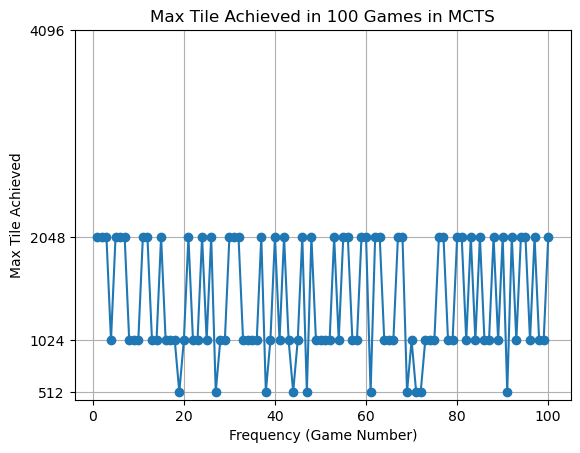

In [89]:
plot_results(max_tiles)

In [73]:
def display_highest_tile_percentages(max_tiles):
    unique, counts = np.unique(max_tiles, return_counts=True)
    percentages = counts / len(max_tiles) * 100
    data = {'Highest Tile': unique, 'Percentage': percentages}
    df = pd.DataFrame(data)
    print(df)

In [75]:
display_highest_tile_percentages(max_tiles)

   Highest Tile  Percentage
0           512        10.0
1          1024        48.0
2          2048        42.0
